# Задание 1

По результатам тестовой рекламной активности на двух каналах подготовлен следующий датасет, включающий установки, затраты на рекламу и платежи пользователей за первые 28 дней жизни

- Все валюты указаны в $ по данным трекинговой системы, не учитывают комиссии магазинов и прочие дополнительные издержки.

- Указаны 2 версии затрат, отличающиеся группировкой.

Опираясь на приведённые данные ответьте на следующие вопросы:

1) Каков CPI и ROAS для каждого источника трафика?

2) Для MediaSource2 рассчитайте конверсию в платящего для пользователей, установивших приложение через Wi-Fi и без него. Достаточно ли данных, чтобы с 95% вероятностью утверждать, что влияние наличия Wi-Fi имеет влияние на конверсию в платящего? Обоснуйте.

3) Выработайте ряд рекомендаций для оптимизации рекламных кампаний, считайте, что ограничений на оптимизацию нет, ваша цель - поднять прибыльность и эффективность маркетинговых кампаний на текущих источниках.

In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy.stats import norm

Installs - установки по юзерам с информацией по трафику, кампаний  и стране

In [2]:
df_installs = pd.read_excel('/content/drive/MyDrive/dataset_kefir.xlsx', sheet_name='Installs')

In [3]:
df_installs.sample(4)

,MediaSource,CampaignID,Channel,Country,Wifi,UserID,OSVersion
13830,MediaSource1,19560305480,Network,ES,True,1675002107838-3708128067707373746,11
2911,MediaSource1,19560305480,Network,UY,False,1675050109067-2982678519847552826,13
8500,MediaSource1,19560305480,Network,BR,False,1675113947322-4048659905923849754,12
13348,MediaSource1,19560305480,Network,SX,True,1674919660332-77660219558688286,11


In [4]:
df_installs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22416 entries, 0 to 22415
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MediaSource  22416 non-null  object
 1   CampaignID   22416 non-null  object
 2   Channel      22416 non-null  object
 3   Country      22409 non-null  object
 4   Wifi         22416 non-null  bool  
 5   UserID       22416 non-null  object
 6   OSVersion    22416 non-null  int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 1.0+ MB


In [5]:
# проверка на дубликаты
df_installs.duplicated().sum()

1

Payments - доход по каждому юзеру

In [6]:
df_payments = pd.read_excel('/content/drive/MyDrive/dataset_kefir.xlsx', sheet_name='Payments')

In [7]:
df_payments.sample(4)

,UserID,PaymentRevenue
1473,1674992672627-2449730529934400636,4.99000
44,1673818368646-7482283760190329185,2.07543
198,1673670959707-4461760122653175614,4.99000
1178,1673924305842-2138606797448681330,4.99000


In [8]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580 entries, 0 to 1579
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          1580 non-null   object 
 1   PaymentRevenue  1580 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.8+ KB


Cost_v1 - разбивка кампании по странам и их стоимость

In [9]:
df_cost_v1 = pd.read_excel('/content/drive/MyDrive/dataset_kefir.xlsx', sheet_name='Cost_v1')

In [10]:
df_cost_v1.sample(4)

,MediaSource,CampaignID,Country,Cost
257,MediaSource1,19560305480,KY,0.065178
358,MediaSource1,19560308588,WS,0.003696
170,MediaSource1,19560305480,NL,39.428045
428,MediaSource1,19560308588,UZ,3.322457


In [11]:
df_cost_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MediaSource  435 non-null    object 
 1   CampaignID   435 non-null    object 
 2   Country      431 non-null    object 
 3   Cost         435 non-null    float64
dtypes: float64(1), object(3)
memory usage: 13.7+ KB


Cost_v2 - кампании и их стоимость

In [12]:
df_cost_v2 = pd.read_excel('/content/drive/MyDrive/dataset_kefir.xlsx', sheet_name='Cost_v2')

In [14]:
df_cost_v2.head(4)

,MediaSource,CampaignID,Channel,Cost
0,MediaSource1,19560308588,Network,2594.512900
1,MediaSource1,19560305480,Network,2661.085983
2,MediaSource1,19560308588,Search,1206.427759
3,MediaSource1,19560305480,Search,1105.145814


In [18]:
# Затраты на РК
df_cost_v2.groupby('CampaignID')['Cost'].sum()

CampaignID
19560305480          3778.663255
19560308588          3887.534905
lQX9cNlleNjAtuzw    12260.199500
Name: Cost, dtype: float64

In [15]:
df_cost_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MediaSource  24 non-null     object 
 1   CampaignID   24 non-null     object 
 2   Channel      24 non-null     object 
 3   Cost         24 non-null     float64
dtypes: float64(1), object(3)
memory usage: 896.0+ bytes


*1*) Каков CPI и ROAS для каждого источника трафика?

CPI

In [19]:
# посчитаем затраты по источникам MediaSource
df_cost_v2.groupby('MediaSource')['Cost'].sum()

MediaSource
MediaSource1     7666.19816
MediaSource2    12260.19950
Name: Cost, dtype: float64

In [20]:
# посчитаем кол-во скачиваний по источнику
df_installs.groupby('MediaSource')['MediaSource'].count()

MediaSource
MediaSource1    19717
MediaSource2     2699
Name: MediaSource, dtype: int64

In [21]:
cpi_md1 = df_cost_v2.groupby('MediaSource')['Cost'].sum()[0]/df_installs.groupby('MediaSource')['MediaSource'].count()[0]
cpi_md2 = df_cost_v2.groupby('MediaSource')['Cost'].sum()[1]/df_installs.groupby('MediaSource')['MediaSource'].count()[1]

In [22]:
print(f'MediaSource1 : CPI - {cpi_md1.round(2)} $')
print(f'MediaSource2 : CPI - {cpi_md2.round(2)} $')

MediaSource1 : CPI - 0.39 $
MediaSource2 : CPI - 4.54 $


ROAS

In [23]:
# Доход от каждого источника трафика
df_payments.merge(df_installs[['UserID', 'MediaSource']], on='UserID', how='left').groupby('MediaSource')['PaymentRevenue'].sum()

MediaSource
MediaSource1    4977.337570
MediaSource2    6857.231789
Name: PaymentRevenue, dtype: float64

In [21]:
roas_md1 = df_payments.merge(df_installs[['UserID', 'MediaSource']], on='UserID', how='left').groupby('MediaSource')['PaymentRevenue'].sum()[0]/df_cots_v2.groupby('MediaSource')['Cost'].sum()[0]
roas_md2 = df_payments.merge(df_installs[['UserID', 'MediaSource']], on='UserID', how='left').groupby('MediaSource')['PaymentRevenue'].sum()[1]/df_cots_v2.groupby('MediaSource')['Cost'].sum()[1]

In [22]:
print(f'MediaSource1 : ROAS - {roas_md1.round(2)}')
print(f'MediaSource2 : ROAS - {roas_md2.round(2)}')

MediaSource1 : ROAS - 0.65
MediaSource2 : ROAS - 0.56


**2) Для MediaSource2 рассчитайте конверсию в платящего для пользователей, установивших приложение через Wi-Fi и без него. Достаточно ли данных, чтобы с 95% вероятностью утверждать, что влияние наличия Wi-Fi имеет влияние на конверсию в платящего? Обоснуйте.**

Конверсия в платещего с вифи или без

In [23]:
count_wifi = df_installs.query('Wifi == True and MediaSource == "MediaSource2"')['MediaSource'].count()
count_no_wifi = df_installs.query('Wifi == False and MediaSource == "MediaSource2"')['MediaSource'].count()

In [24]:
print(f'Кол-во установок c помощью Wi-fi - {count_wifi}')
print(f'Кол-во установок c без использования Wi-fi - {count_no_wifi}')

Кол-во установок c помощью Wi-fi - 1711
Кол-во установок c без использования Wi-fi - 988


In [25]:
df_ms2 = df_installs.query('MediaSource == "MediaSource2"')[['UserID', 'Wifi']].merge(df_payments.groupby('UserID')['PaymentRevenue'].sum(), on='UserID', how='left').fillna(0)

In [26]:
df_ms2.sample(4)

,UserID,Wifi,PaymentRevenue
262,1674352832421-5885321291403003920,True,0.00
2157,1673542936766-8087092629709112870,True,9.99
292,1674967320184-3905686691832367176,True,0.00
867,1672670279808-1130321186590138414,True,0.00


In [27]:
count_pay_wifi = df_ms2.query('Wifi == True and PaymentRevenue > 0').count()[0]
count_pay_no_wifi = df_ms2.query('Wifi == False and PaymentRevenue > 0').count()[0]
print(f'Кол-во платящих , установленных по Wi-fi - {count_pay_wifi}')
print(f'Кол-во платящих , установленных без Wi-fi - {count_pay_no_wifi}')

Кол-во платящих , установленных по Wi-fi - 104
Кол-во платящих , установленных без Wi-fi - 72


In [45]:
print(f'Конверсию в платящего для пользователей из истоника MediaSource2, установивших приложение через Wi-Fi - {(count_pay_wifi*100/count_wifi).round(1)}%')
print(f'Конверсию в платящего для пользователей из истоника MediaSource2, установивших приложение без Wi-Fi - {(count_pay_no_wifi*100/count_no_wifi).round(1)}%')

Конверсию в платящего для пользователей из истоника MediaSource2, установивших приложение через Wi-Fi - 6.1%
Конверсию в платящего для пользователей из истоника MediaSource2, установивших приложение без Wi-Fi - 7.3%


P.S. в листе cost v1 затесалась одна строка

MediaSource2	lQX9cNlleNjAtuzw	US	12260,1995

В рассчеты я ее не учитывал исходя , из ошибочного добавления или дублирования данной строки.

Для проверки статистической значимости различия между конверсиями,
воспользуемся  тестом на разность долей.

Нулевая гипотеза (H0): Наличие Wi-Fi не оказывает влияния на конверсию в платящего пользователей.
Альтернативная гипотеза (H1): Наличие Wi-Fi оказывает влияние на конверсию в платящего пользователей.



In [29]:
import statsmodels.api as sm

# Создание массивов данных для теста на разность долей
successes = [count_pay_wifi, count_pay_no_wifi]
nobs = [count_wifi, count_no_wifi]

# Выполнение теста на разность долей
zscore, pvalue = sm.stats.proportions_ztest(successes, nobs)

# Вывод результатов теста
print(f"Z-score: {zscore.round(2)}")
print(f"P-value: {pvalue.round(2)}")

Z-score: -1.23
P-value: 0.22


P-value равно 0.22, что представляет вероятность получить такие или более экстремальные различия между группами (Wi-Fi и без Wi-Fi) при условии, что нулевая гипотеза верна (то есть, что наличие Wi-Fi не оказывает влияния на конверсию в платящего). Значение p-value равно 0.22, что больше обычно выбранного уровня значимости 0.05.

**3) Выработайте ряд рекомендаций для оптимизации рекламных кампаний, считайте, что ограничений на оптимизацию нет, ваша цель - поднять прибыльность и эффективность маркетинговых кампаний на текущих источниках.**

Для решения данного вопроса, будем работать с рекламными компаниями из источника MediaSource1

In [18]:
df_ms1 = df_installs.query('MediaSource == "MediaSource1"')[['CampaignID', 'Channel', 'Country', 'Wifi', 'UserID', 'OSVersion']]
df_ms1.sample(4)

,CampaignID,Channel,Country,Wifi,UserID,OSVersion
15853,19560305480,Network,MN,True,1674112508499-6366352125753461713,10
4657,19560308588,Network,CL,True,1673833081728-507700146714314965,12
7859,19560305480,Network,CL,True,1674946481940-9080669291718269051,12
12945,19560308588,Network,JP,True,1674822855130-7593899074878987041,11


In [34]:
df_ms1.shape

(19717, 6)

In [32]:
# Таблицы для каждой РК
df_ms1_80 = df_ms1.query('CampaignID == 19560305480')
df_ms1_88 = df_ms1.query('CampaignID == 19560308588')

In [77]:
df_cost_v1.query('CampaignID == 19560305480')[['Country', 'Cost']].head(3)

,Country,Cost
0,UG,0.628868
1,MW,0.253214
3,LR,0.046751


In [78]:
df_ms1_80.groupby('Country')['Country'].count().reset_index(name='Installs').head(3)

,Country,Installs
0,AD,3
1,AE,5
2,AG,2


In [90]:
df_ms1_80_reg_cpi = df_cost_v1.query('CampaignID == 19560305480')[['Country', 'Cost']].merge(df_ms1_80.groupby('Country')['Country'].count().reset_index(name='Installs'), on='Country', how='left').fillna(0)

df_ms1_80_reg_cpi['CPI'] = df_ms1_80_reg_cpi['Cost'] / df_ms1_80_reg_cpi['Installs']
df_ms1_80_reg_cpi['CPI'] = df_ms1_80_reg_cpi['CPI'].replace([np.inf, -np.inf], 0)
df_ms1_80_reg_cpi.fillna(0, inplace=True)

df_ms1_80_reg_cpi.sample(3)

,Country,Cost,Installs,CPI
102,PS,1.212685,26.0,0.046642
213,LV,16.469726,41.0,0.401701
209,KM,0.047379,0.0,0.000000


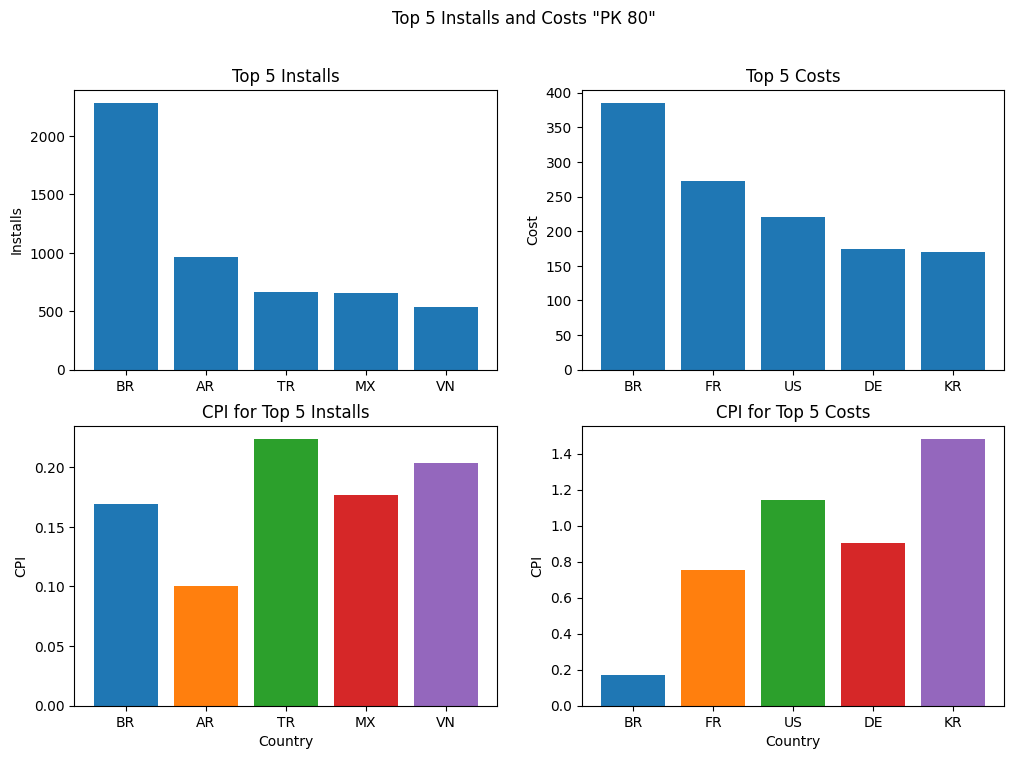

In [108]:
df_sorted_installs = df_ms1_80_reg_cpi.sort_values('Installs', ascending=False).head(5)
df_sorted_costs = df_ms1_80_reg_cpi.sort_values('Cost', ascending=False).head(5)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Top 5 Installs and Costs "РК 80"')

# топ 5 инсталлов
axs[0, 0].bar(df_sorted_installs['Country'], df_sorted_installs['Installs'])
axs[0, 0].set_title('Top 5 Installs')
axs[0, 0].set_ylabel('Installs')

# топ 5 затрат
axs[0, 1].bar(df_sorted_costs['Country'], df_sorted_costs['Cost'])
axs[0, 1].set_title('Top 5 Costs')
axs[0, 1].set_ylabel('Cost')

# CPI для топ 5 инсталлов
for i, country in enumerate(df_sorted_installs['Country']):
    cpi_value = df_sorted_installs[df_sorted_installs['Country'] == country]['CPI'].values[0]
    axs[1, 0].bar(country, cpi_value)

axs[1, 0].set_title('CPI for Top 5 Installs')
axs[1, 0].set_xlabel('Country')
axs[1, 0].set_ylabel('CPI')

# CPI для топ 5 затрат
for i, country in enumerate(df_sorted_costs['Country']):
    cpi_value = df_sorted_costs[df_sorted_costs['Country'] == country]['CPI'].values[0]
    axs[1, 1].bar(country, cpi_value)

axs[1, 1].set_title('CPI for Top 5 Costs')
axs[1, 1].set_xlabel('Country')
axs[1, 1].set_ylabel('CPI')
plt.show;

In [34]:
# Доход по РК
df_payments.merge(df_installs[['CampaignID','UserID']], on='UserID', how='left').groupby('CampaignID')['PaymentRevenue'].sum()

CampaignID
19560305480         2499.103760
19560308588         2478.233810
lQX9cNlleNjAtuzw    6857.231789
Name: PaymentRevenue, dtype: float64

In [39]:
# Кол-во установок по РК
df_installs.groupby('CampaignID')['CampaignID'].count()

CampaignID
19560305480         13271
19560308588          6446
lQX9cNlleNjAtuzw     2699
Name: CampaignID, dtype: int64

In [35]:
# Кол-во платящих
df_payments.merge(df_installs[['CampaignID','UserID']], on='UserID', how='left').groupby('CampaignID')['PaymentRevenue'].count()

CampaignID
19560305480         469
19560308588         425
lQX9cNlleNjAtuzw    686
Name: PaymentRevenue, dtype: int64

В итоге:

Количество установок: RK-80 - 6427 установок, RK-88 - 13224 установок.

Количество платящих пользователей: RK-80 - 425 юзеров, RK-88 - 469  юзеров.

Затраты на рекламу: RK-80 - 3887.534905, RK-88 - 3778.6

Доходы от рекламы: RK-80 - 2478.233810, RK-88 - 2499.1


Нулевая гипотеза (H0): Конверсия в платящего пользователей в рекламной кампании RK-80 и RK-88 одинакова.

Альтернативная гипотеза (H1): Конверсия в платящего пользователей в рекламной кампании RK-80 отличается от конверсии в рекламной кампании RK-88.

In [41]:
installs_RK80 = 6427
installs_RK88 = 13224
paying_users_RK80 = 425
paying_users_RK88 = 469

conversion_RK80 = paying_users_RK80 / installs_RK80
conversion_RK88 = paying_users_RK88 / installs_RK88


p1 = conversion_RK80
p2 = conversion_RK88
n1 = installs_RK80
n2 = installs_RK88

p_combined = (paying_users_RK80 + paying_users_RK88) / (installs_RK80 + installs_RK88)
se = np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
z = (p1 - p2) / se
p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"Conversion rate for RK-80: {conversion_RK80:.4f}")
print(f"Conversion rate for RK-88: {conversion_RK88:.4f}")
print(f"Z-score: {z:.4f}")
print(f"P-value: {p_value:.4f}")

Conversion rate for RK-80: 0.0661
Conversion rate for RK-88: 0.0355
Z-score: 9.6765
P-value: 0.0000


Мы получили Z-значение равное 9.6765 и P-значение равное 0.0000. Поскольку P-значение меньше уровня значимости 0.05, мы отвергаем нулевую гипотезу и принимаем альтернативную гипотезу.

Таким образом, на основе статистического анализа можно сделать вывод, что конверсия в платящего пользователя в рекламной кампании RK-80 статистически значимо отличается от конверсии в рекламной кампании RK-88.

Также выполним непараметрический тест Манна-Уитни, для подтверждения предыдущего
вывода. Нулевую и альтернативную гипотезы оставим без изменений.


In [43]:
from scipy.stats import mannwhitneyu
statistic, p_value = mannwhitneyu([1] * paying_users_RK80 + [0] * (installs_RK80 - paying_users_RK80),[1] * paying_users_RK88 + [0] * (installs_RK88 - paying_users_RK88))

print("Mann-Whitney U-статистика:", statistic)
print("P-значение:", p_value)

Mann-Whitney U-статистика: 43798292.5
P-значение: 3.802546684380839e-22


 В данном случае, P-значение очень близко к нулю. Это означает, что существует очень низкая вероятность получить такие или более экстремальные различия между группами.

 Таким образом, полученное P-значение говорит о статистической значимости различий между группами. Мы можем отвергнуть нулевую гипотезу и сделать вывод о статистически значимом различии между RK-80 и RK-88 по метрике конверсии в платящего пользователя.

В ходе решения пришел, я сделал вывод ,что будет нагляднее сделать дэшбоард в Табло, ссылку с дэшом прилагаю: https://public.tableau.com/app/profile/amiran.mkrtchyan/viz/__8088/sheet6?publish=yes

Вывод:

RK-80 привлекла в 2 раза больше установок (6427) по сравнению с RK-88 (13224), что говорит о более эффективной привлекательности пользователей по более низкой цене. Учитывая это, рекомендуется сосредоточиться на оптимизации монетизации в в RK-80, чтобы повысить средний доход от каждого платящего пользователя.

Однако, кампания RK-88 имеет значительно более высокий показатель конверсии клиентов в платящих (469) по сравнению с RK-80 (425). Это говорит о более высоком уровне заинтересованности и готовности пользователей платить за продукт. Дополнительно, средний чек платящих пользователей в RK-88 на 5 центов выше. Исходя из этого, следует усилить маркетинговые усилия для дальнейшего привлечения большего числа пользователей.

# Задание 2

**Какие основные методы и модели атрибуции существуют для проектов на iOS? Укажите преимущества и критические ограничения в различных методах.**

* SKAdNetwork - это метод, который выполняется непосредственно на устройстве пользователя. Он предоставляет детерминированные данные об атрибуции, то есть указывает, какие рекламные источники привели к установке приложения. Однако у этого метода есть ограничения, такие как ограниченные возможности измерения дохода после установки (LTV) и неполное охватывание всех типов потоков.

* ATT-consented users, это модель атрибуции, которая основана на сопоставлении идентификаторов пользователей. Она позволяет точно сопоставлять данные с различных источников и определять, какие рекламные кампании привели к установкам. Однако для этого метода требуется согласие пользователей на отслеживание (App Tracking Transparency), что может ограничить доступность данных.

* Non-consented users, это модель атрибуции, которая использует агрегированные данные и вероятностное моделирование. Она позволяет анализировать данные без требования согласия от пользователей. Однако у этого метода могут быть ограничения в точности и детерминированности данных, а также в измерении LTV и других метрик.

Как я понял, все данные для этого тестового - это логи ios-юзеров  первого фидбека от scan4

# Задание 3

**Увас в работе находится игра, каждый уровень которой проходится за 3 минуты ровно. При прохождении уровня игрок сразу попадает на следующий. Вероятность проигрыша для каждого уровня и игрока одинакова и равняется 75% - тогда игроку предстоит начать прохождение уровня заново. Проиграть можно в любой момент времени. Также после каждой победы или поражения игрок с 20% вероятностью ставит игру на паузу продолжительностью 10-30 секунд. Сколько уровней вероятнее всего игрок пройдёт за 1 час?**

Приложите полное решение задачи или же изложите логику рассуждений.

In [122]:
import random

def play_game():
    levels_passed = 0
    time_passed = 0

    while time_passed < 60:  # Игровое время в минутах (1 час = 60 минут)
        time_passed += 3  # Прохождение одного уровня занимает 3 минуты

        if random.random() <= 0.75:  # Вероятность проигрыша на уровне: 75%
            continue  # Игрок проигрывает и переходит к следующему уровню

        levels_passed += 1  # Игрок побеждает и переходит к следующему уровню

        if random.random() <= 0.2:  # Вероятность паузы после победы: 20%
            pause_duration = random.randint(10, 30)  # Продолжительность паузы в секундах
            time_passed += pause_duration / 60  # Преобразование продолжительности паузы в минуты

    return levels_passed

# Проводим моделирование игры
num_simulations = 10000  # Количество моделирований
total_levels_passed = 0

for _ in range(num_simulations):
    levels_passed = play_game()
    total_levels_passed += levels_passed

# Рассчитываем ожидаемое количество пройденных уровней за 1 час
expected_levels_passed = total_levels_passed / num_simulations

print(f"Ожидаемое количество пройденных уровней за 1 час: {np.round(expected_levels_passed)}")

Ожидаемое количество пройденных уровней за 1 час: 5.0


# Задание 4

Назовите ТОП 5 мобильных игр и кратко опишите основные механики этих игр.

* Wild Rift: Мобильная командная игра 5 на 5 с уникальными чемпионами и целью уничтожить базу противника. (я брал рейтинг топ-300 на eu)
* Hearthstone: Карточная игра, где игроки сражаются с помощью карт, контролируют поле и достигают условий победы. (топ-800 на eu)
* Diablo: Экшн-ролевая игра, включающая исследование подземелий, сражения с врагами, сбор лута и развитие персонажа.
* PUBG: Многопользовательская игра с выживанием, где игроки сражаются за выживание на огромной карте, собирают оружие и экипировку, и стремятся стать последним выжившим.
* Clash Royale: Многопользовательская стратегическая игра с коллекционными картами и турнирами. Игроки собирают и улучшают карты, формируют колоду, и сражаются против других игроков в режиме реального времени. Целью игры является уничтожение башен противника и защита своих собственных башен, используя различные карты с юнитами и заклинаниями.